# Final Project

## 4/20/2025

- Team Members
    - Brittney Bedrossian
    - Breenda Shah
    - Jeb Besecker
    - Kevin Dennin
    - Kohry Long

### This serves as an initial exploration and data pre processing module. 

# Imports 

In [48]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#import graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Changelog Intialization

In [49]:
# Initilize changelog
changelog = []

# Data Load

In [50]:
# Load the dataset
df = pd.read_csv("../Data/loan_data.csv")
df.head()


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,female,Master,71948,0,RENT,35000,PERSONAL,16.02,0.49,3,561,No,1
1,21,female,High School,12282,0,OWN,1000,EDUCATION,11.14,0.08,2,504,Yes,0
2,25,female,High School,12438,3,MORTGAGE,5500,MEDICAL,12.87,0.44,3,635,No,1
3,23,female,Bachelor,79753,0,RENT,35000,MEDICAL,15.23,0.44,2,675,No,1
4,24,male,Master,66135,1,RENT,35000,MEDICAL,14.27,0.53,4,586,No,1


In [51]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int64  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  int64  
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  int64  
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  int64  
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [52]:
df.describe()


,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


<Axes: >

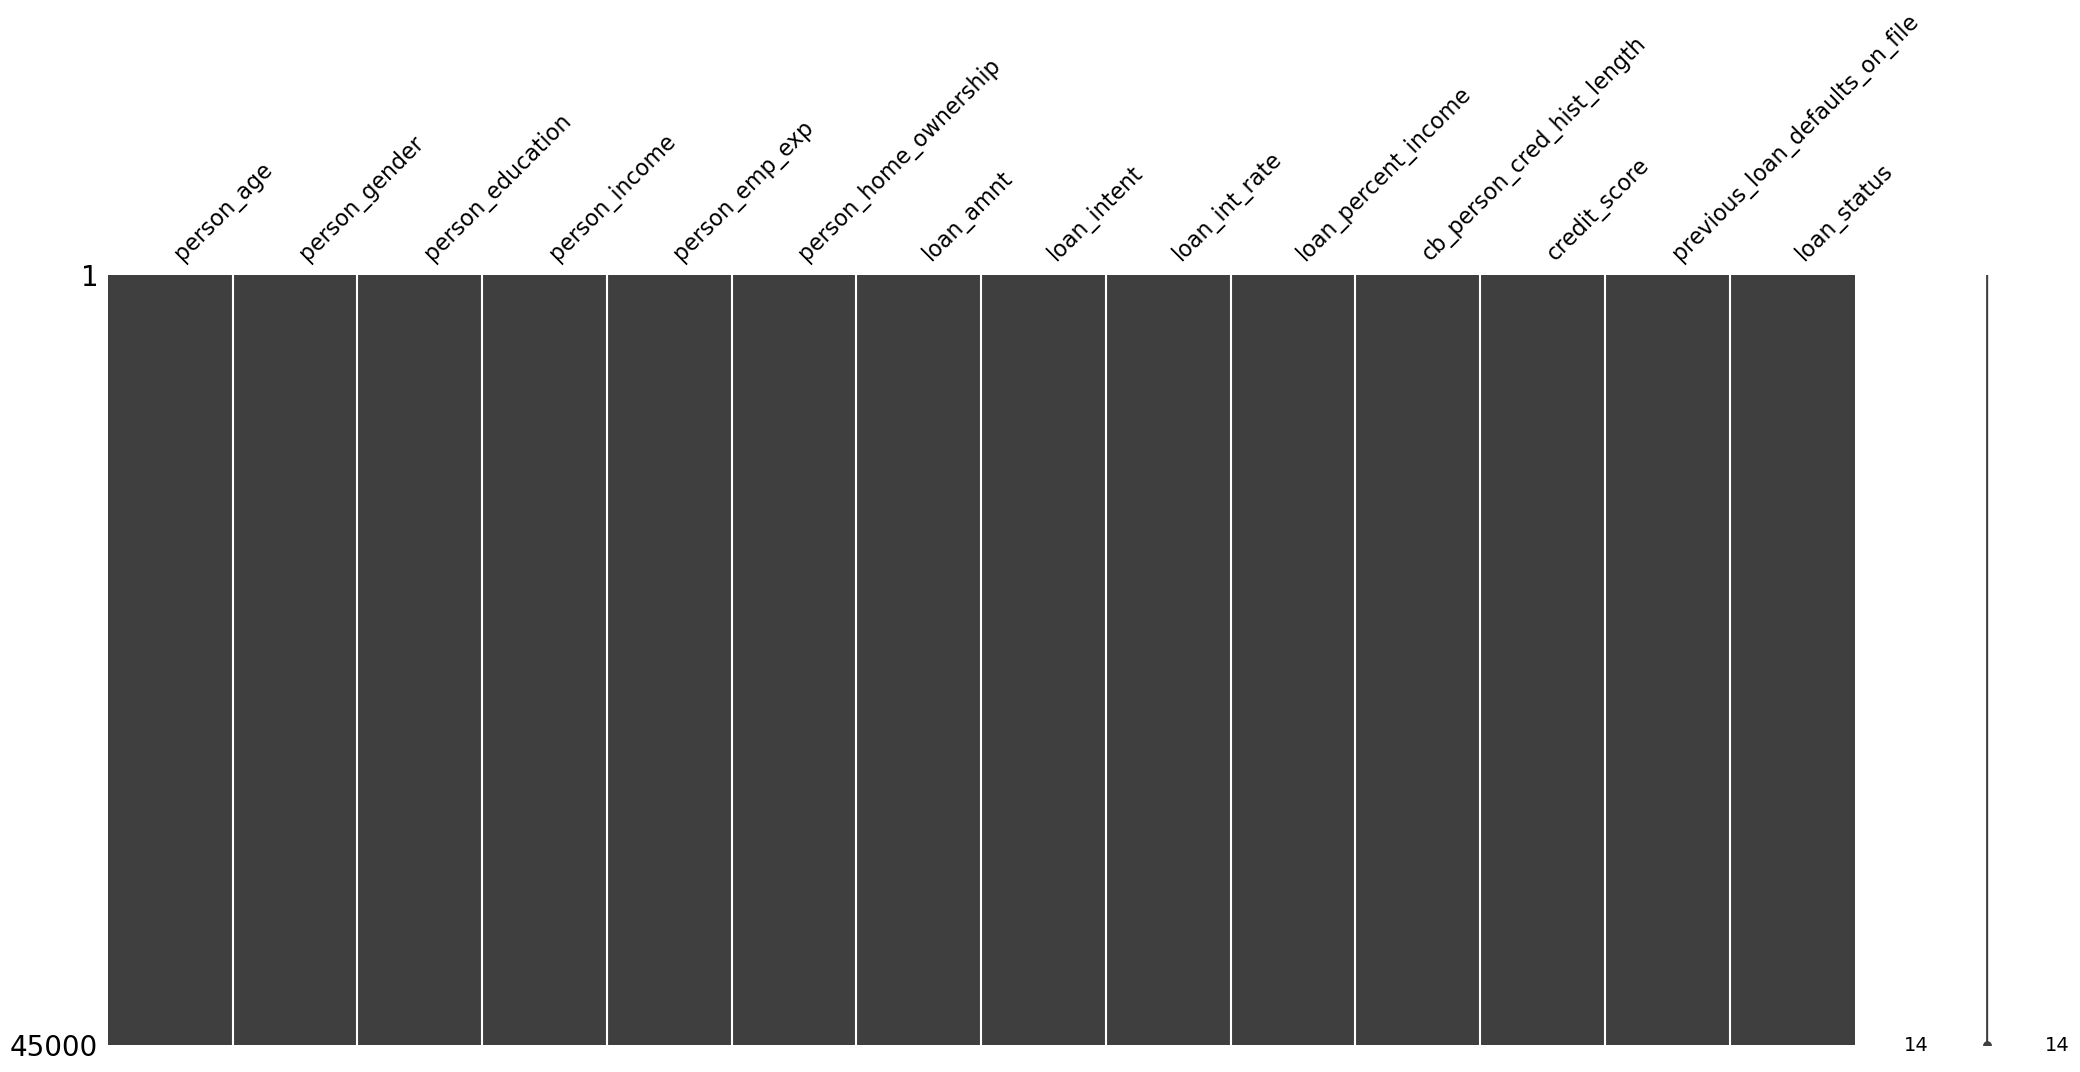

In [53]:
# Explore MissingNo
mno.matrix(df)

# Data Exploration and Categorical Analysis

In [54]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


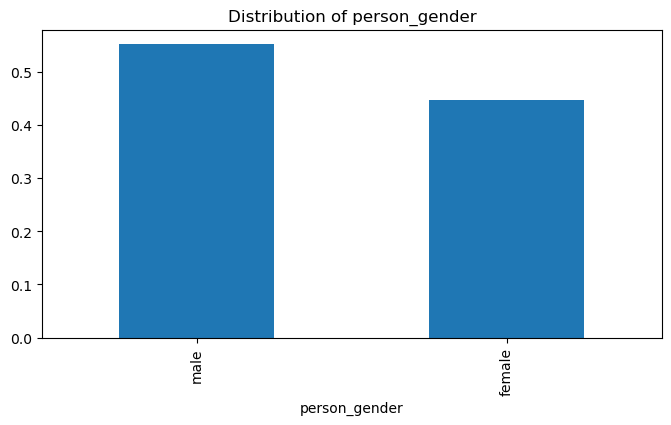

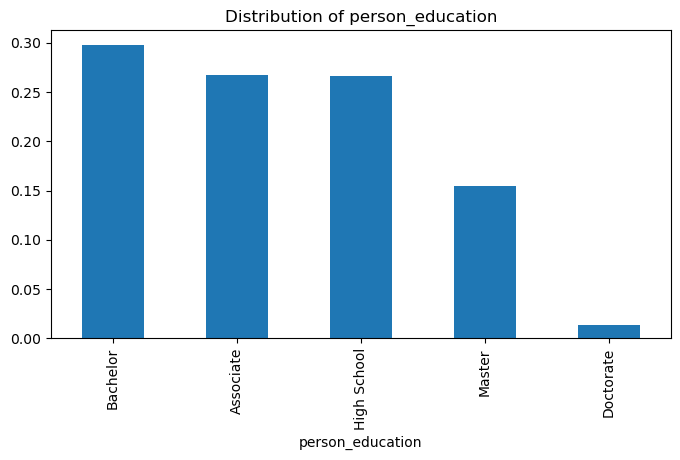

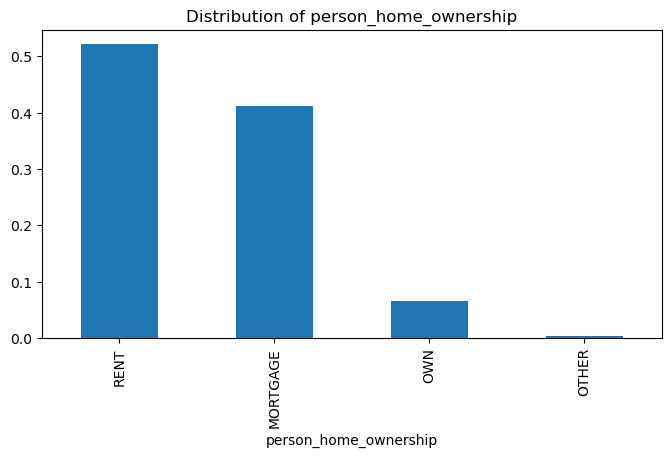

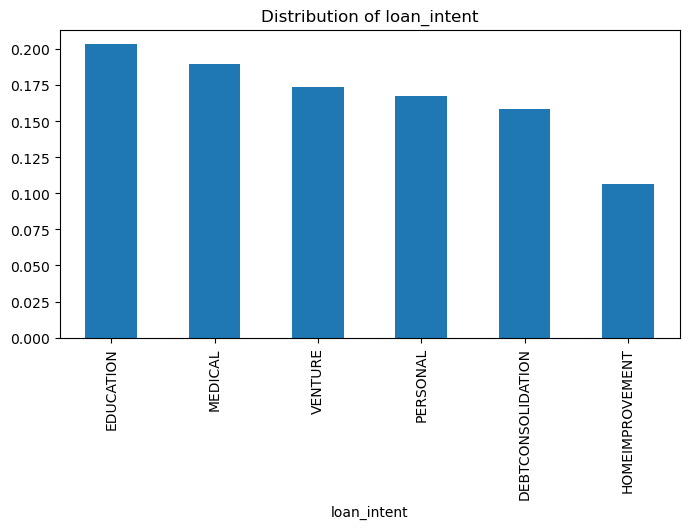

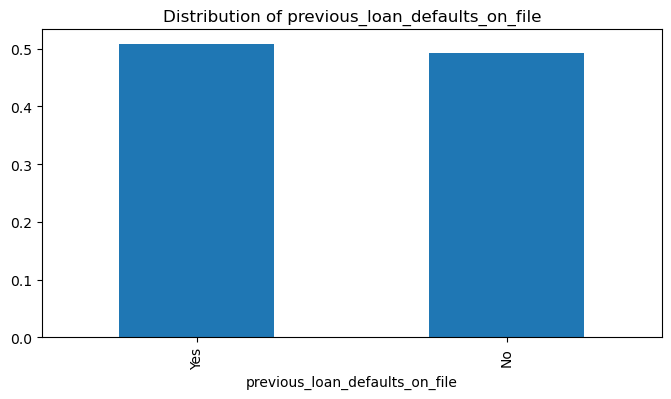

In [55]:
# Univariate analysis of categorical variables
for col in categorical_columns:
    fig = plt.figure(figsize=(8, 4))
    df[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.show()

# Notes on Categorical Analysis:
- No spelling mistakes
- Person Home ownership needs to be grouped on owned or other. Or other removed entirely
- Overall spread of other categorical variables solid. One exception, person_education (Doctorate small subgroup)

# Numerical Analysis

Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


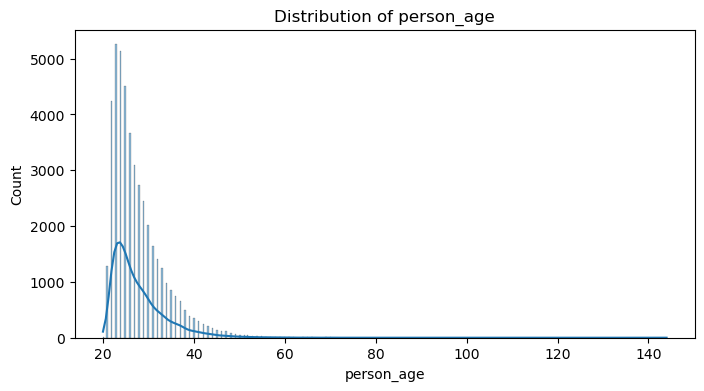

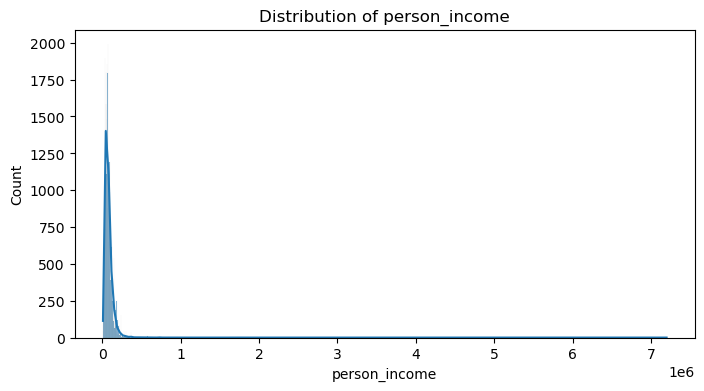

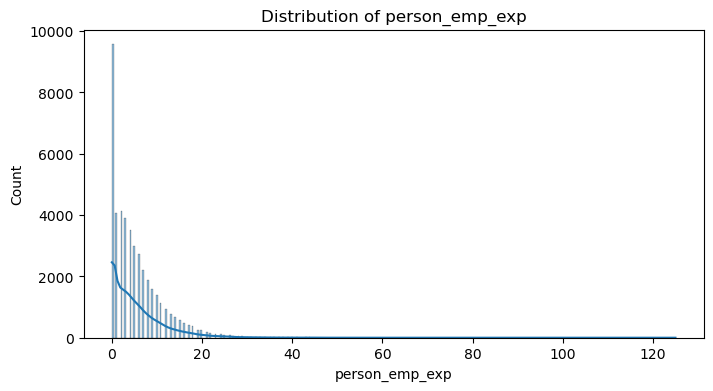

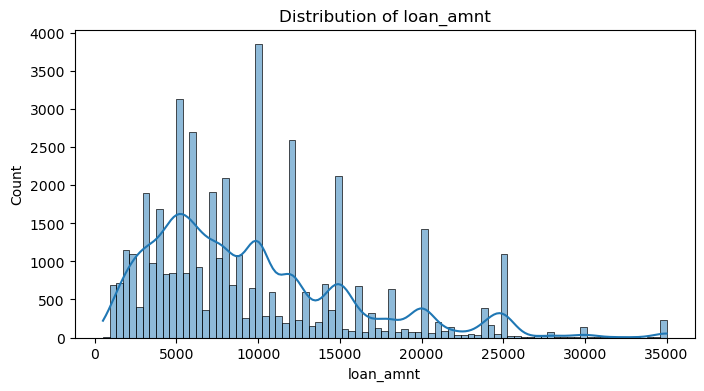

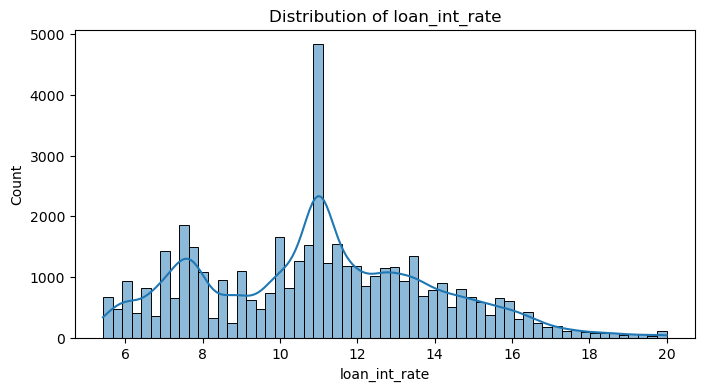

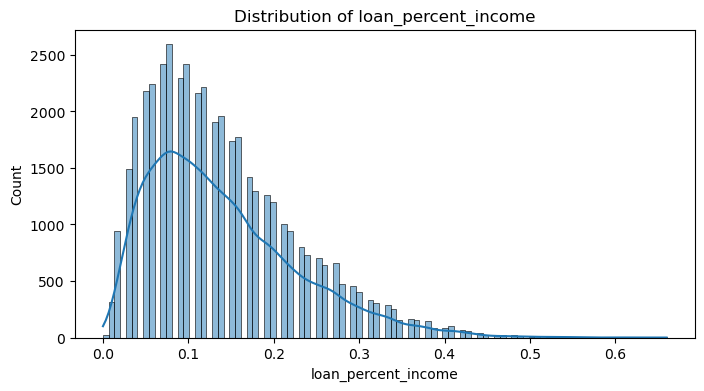

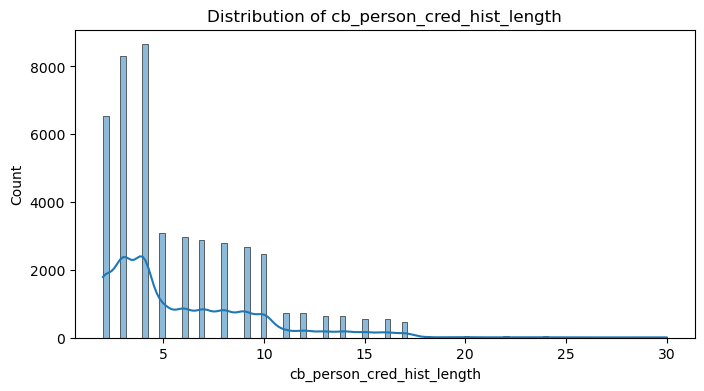

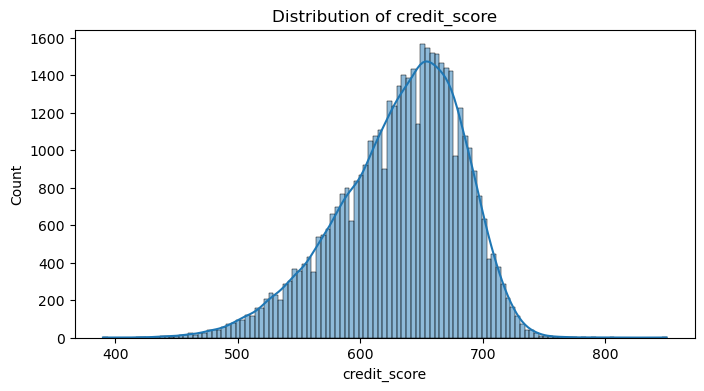

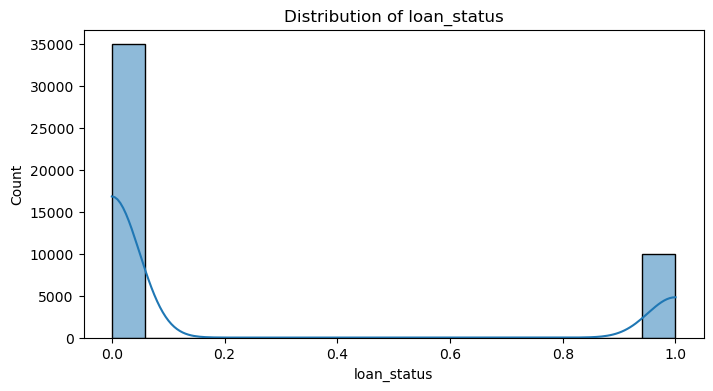

In [56]:
# Univariate analysis of numerical variables
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", numerical_columns)
for col in numerical_columns:
    fig = plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

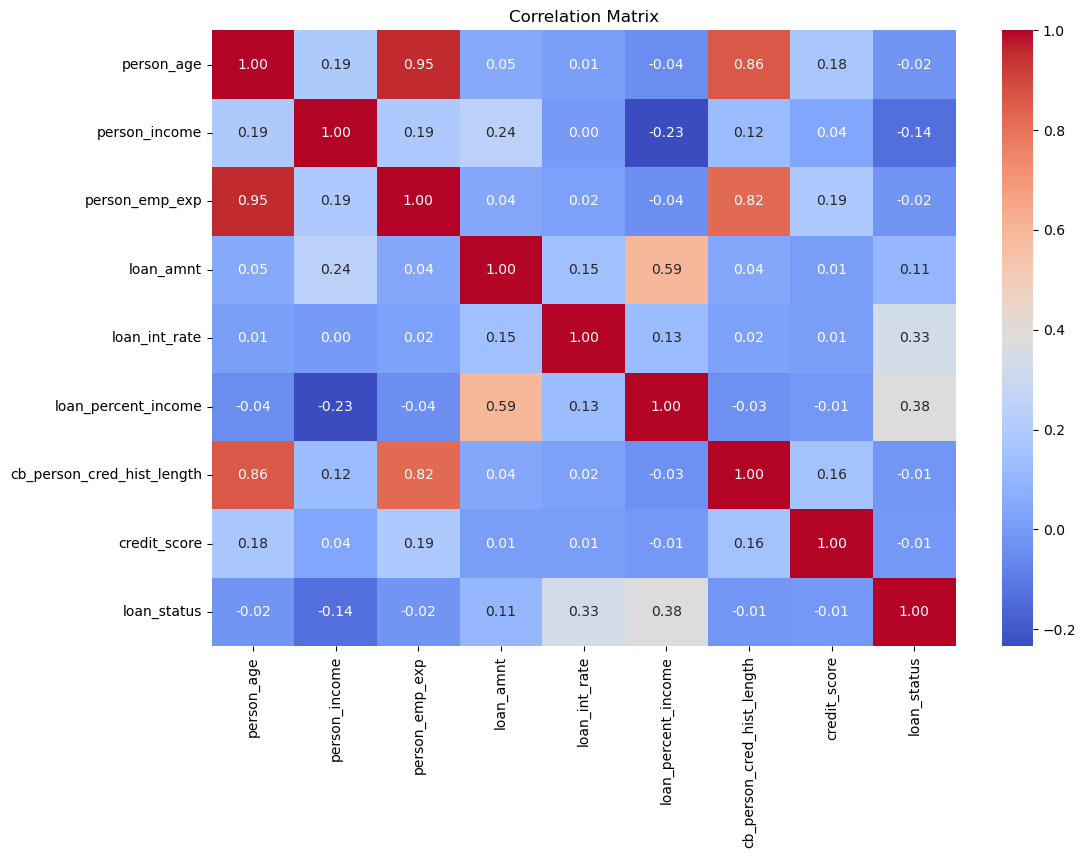

In [57]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


From the output, we can see that there is a strong positive correlation (0.95) between **person_emp_exp** and **person_age** which is counterintuitive, since the older a person is, the more likely they are to have more work experience. There is also a strong, positive correlation (0.86) between **cb_person_cred_hist_length** and **person_age** since the older a person is, the longer their credit history is likely to be. Based on these correlations and for the same reason, it makes sense that **person_emp_exp** and **cb_person_cred_hist_length** have a strong, positive correlation (0.82).

# Data Cleaning & Preprocessing

In [58]:
# Copy original df to df_cleaned
df_cleaned = df.copy()

<h4> Numerical Variables </h4>

In [59]:
# Remove unrealistic ages
original_row_count = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['person_age'] <= 125]
removed_count = original_row_count - df_cleaned.shape[0]


changelog.append({
    'column': 'age',
    'change': f'Removed {removed_count} row(s) where age > 125',
    'rationale': 'Oldest verified human lived to be 122; values above 125 are likely errors or outliers.',
})


In [60]:
# Drop loan_status column
df_cleaned.drop(columns=['loan_status'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
changelog.append({
    'column': 'loan_status',
    'change': 'Dropped loan_status column',
    'rationale': 'Target variable for classification; not needed in cleaned dataset.',
})


Numerical columns after capping: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


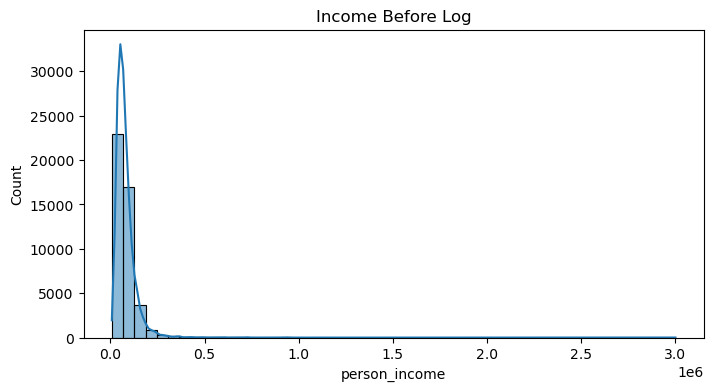

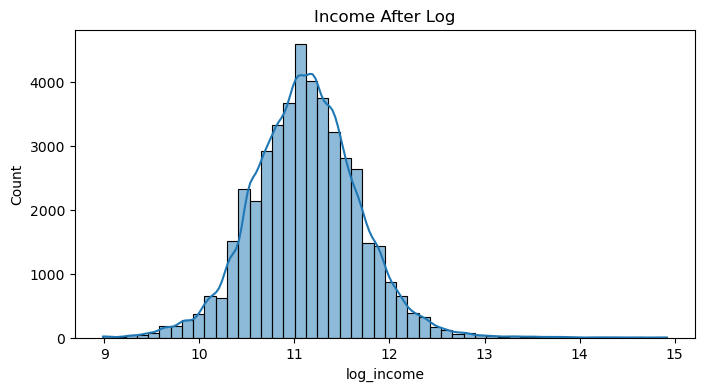

In [61]:
# Cap outliers before log-transform
df_cleaned['person_income'] = np.where(df_cleaned['person_income'] > 3_000_000, 3_000_000, df_cleaned['person_income'])


# Show numerical columns after capping
print("Numerical columns after capping:", numerical_columns)


# Apply log1p to preserve 0s and small values
df_cleaned['log_income'] = np.log1p(df_cleaned['person_income'])
changelog.append({
    'column': 'person_income',
    'change': 'Capped person_income at $3,000,000 and applied log1p transformation',
    'rationale': 'Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.',
})


plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['person_income'], bins=50, kde=True)
plt.title("Income Before Log")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['log_income'], bins=50, kde=True)
plt.title("Income After Log")
plt.show()


In [62]:
# Drop person_income after log-transform
df_cleaned.drop(columns=['person_income'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()


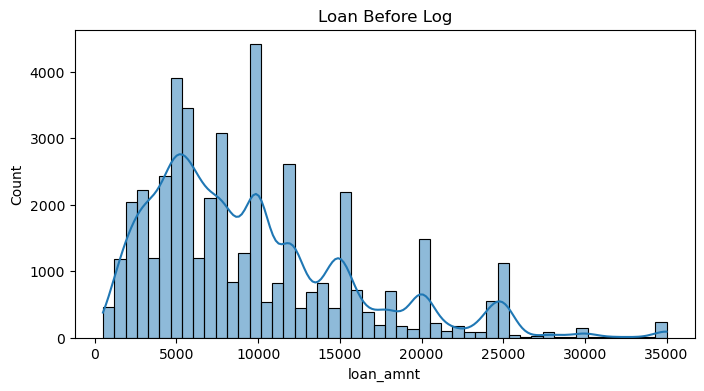

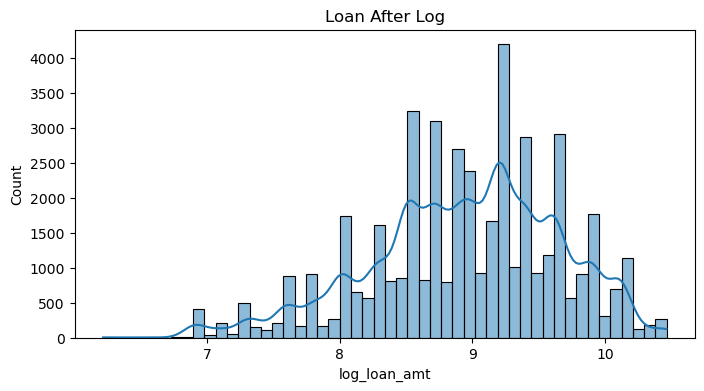

In [63]:
# Apply log1p to preserve 0s and small values
df_cleaned['log_loan_amt'] = np.log1p(df_cleaned['loan_amnt'])
changelog.append({
    'column': 'loan_amnt',
    'change': 'Applied log1p transformation to loan_amount',
    'rationale': 'Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.',
})

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['loan_amnt'], bins=50, kde=True)
plt.title("Loan Before Log")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['log_loan_amt'], bins=50, kde=True)
plt.title("Loan After Log")
plt.show()

In [64]:
# Drop loan_amnt after log-transform
df_cleaned.drop(columns=['loan_amnt'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

In [65]:
# Remove unrealistic person_emp_exp values
original_row_count = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['person_emp_exp'] <= 70]
removed_count = original_row_count - df_cleaned.shape[0]
changelog.append({
    'column': 'person_emp_exp',
    'change': f'Removed {removed_count} row(s) where person_emp_exp > 70',
    'rationale': 'Unrealistic employment experience; values above 70 years are likely errors or outliers.',
}) 

In [66]:
# Scale numerical columns using MinMaxScaler
minmax_scaler = MinMaxScaler()
df_cleaned[numerical_columns] = minmax_scaler.fit_transform(df_cleaned[numerical_columns])
df_cleaned.head()


# Changelog for scaling
changelog.append({
    'column': 'numerical_columns',
    'change': 'Scaled numerical columns using MinMaxScaler',
    'rationale': 'Normalized numerical features to a range of [0, 1] for better model performance.',
})


<class 'pandas.core.frame.DataFrame'>
Index: 44992 entries, 0 to 44996
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44992 non-null  float64
 1   person_gender                   44992 non-null  object 
 2   person_education                44992 non-null  object 
 3   person_emp_exp                  44992 non-null  float64
 4   person_home_ownership           44992 non-null  object 
 5   loan_intent                     44992 non-null  object 
 6   loan_int_rate                   44992 non-null  float64
 7   loan_percent_income             44992 non-null  float64
 8   cb_person_cred_hist_length      44992 non-null  float64
 9   credit_score                    44992 non-null  float64
 10  previous_loan_defaults_on_file  44992 non-null  object 
 11  log_income                      44992 non-null  float64
 12  log_loan_amt                    44992

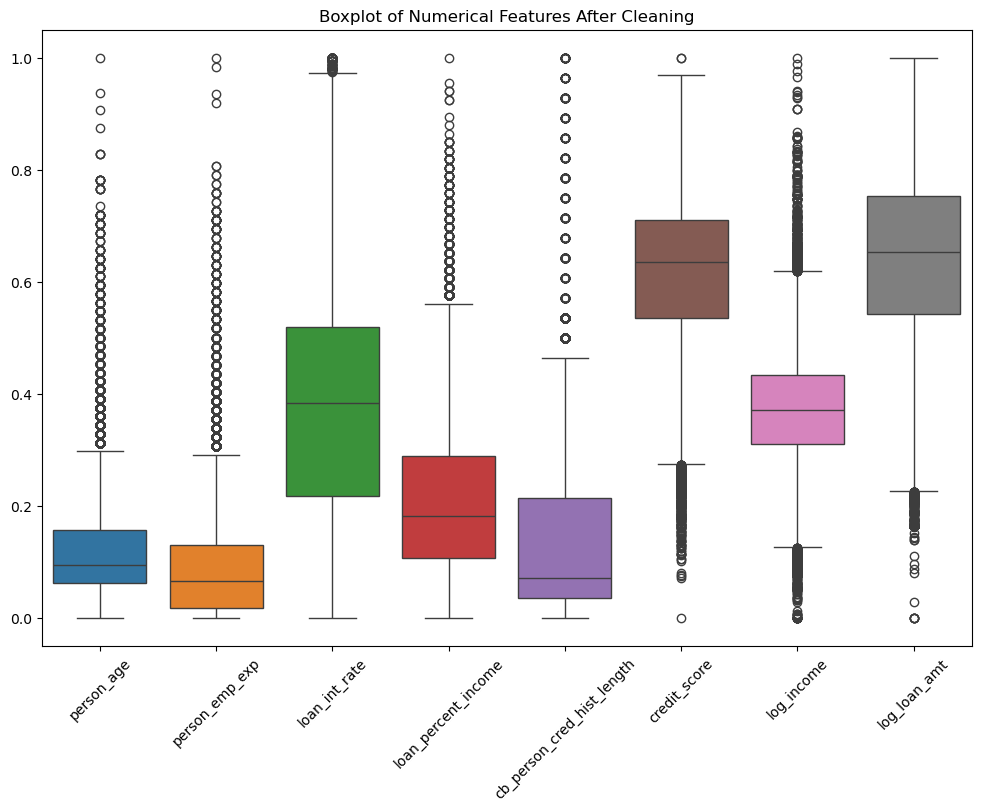

In [67]:
# Check cleaned data
df_cleaned.info()
df_cleaned.describe()

# Plot boxplot for cleaned data
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned[numerical_columns])
plt.title('Boxplot of Numerical Features After Cleaning')
plt.xticks(rotation=45)
plt.show()

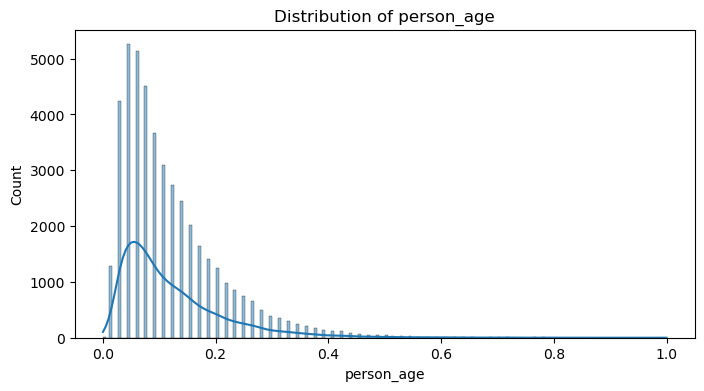

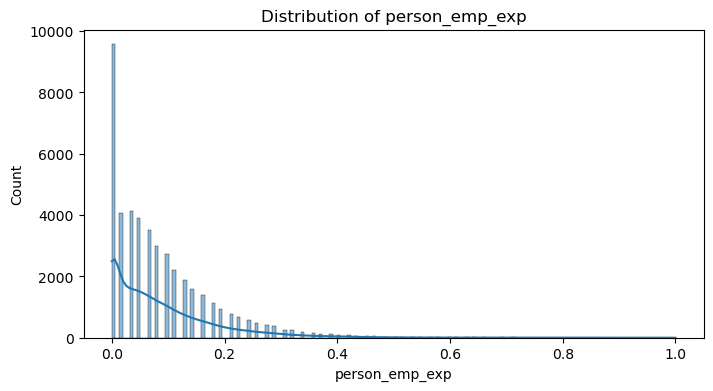

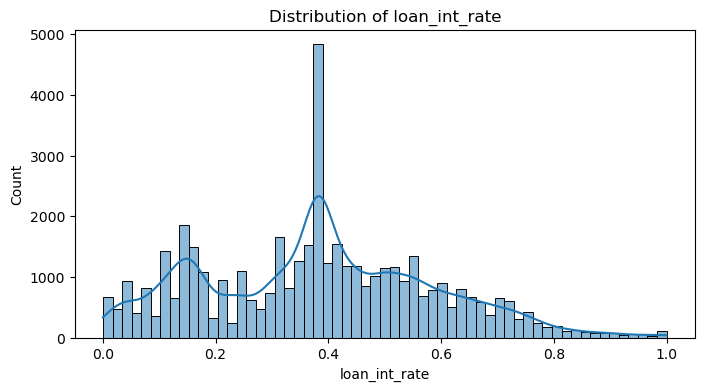

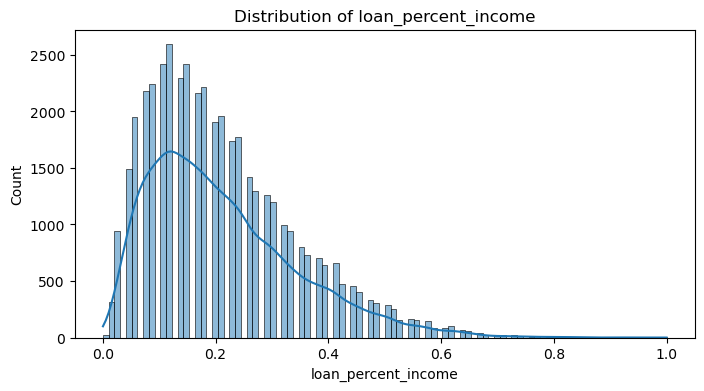

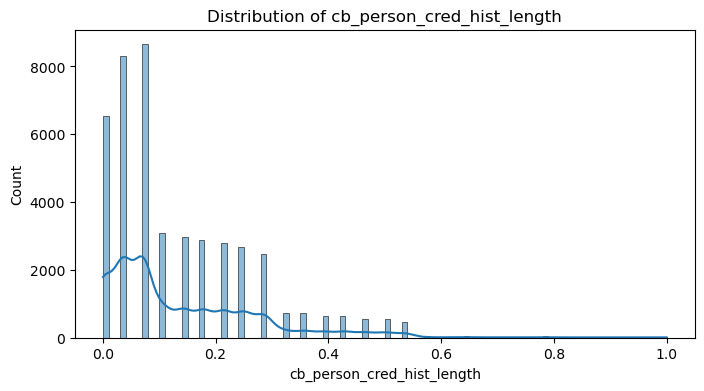

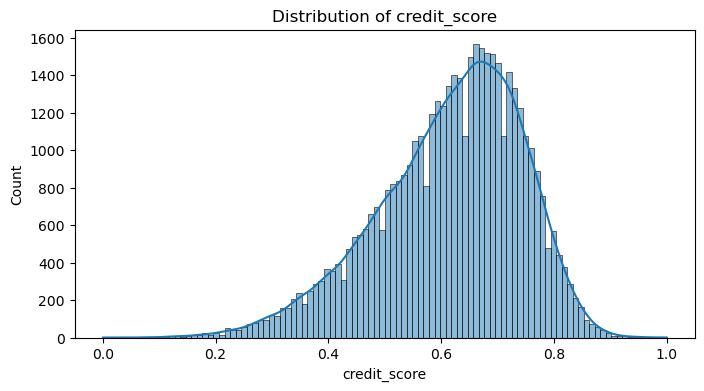

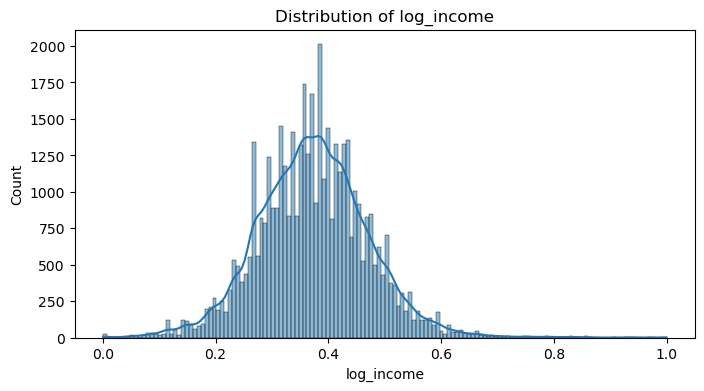

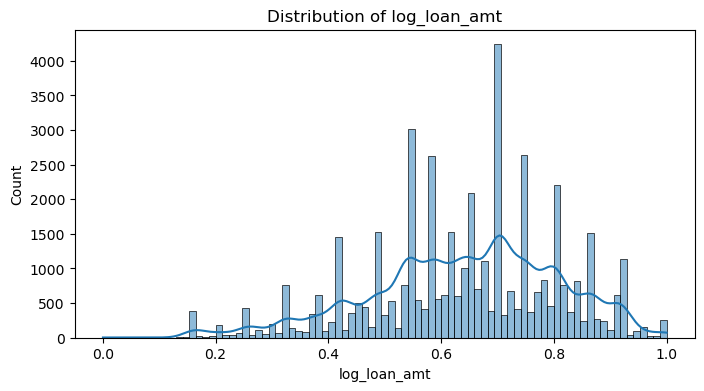

In [68]:
for col in numerical_columns:
    fig = plt.figure(figsize=(8, 4))
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


In [69]:
# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,numerical_columns,Scaled numerical columns using MinMaxScaler,"Normalized numerical features to a range of [0, 1] for better model performance."


<class 'pandas.core.frame.DataFrame'>
Index: 44992 entries, 0 to 44996
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44992 non-null  float64
 1   person_gender                   44992 non-null  object 
 2   person_education                44992 non-null  object 
 3   person_emp_exp                  44992 non-null  float64
 4   person_home_ownership           44992 non-null  object 
 5   loan_intent                     44992 non-null  object 
 6   loan_int_rate                   44992 non-null  float64
 7   loan_percent_income             44992 non-null  float64
 8   cb_person_cred_hist_length      44992 non-null  float64
 9   credit_score                    44992 non-null  float64
 10  previous_loan_defaults_on_file  44992 non-null  object 
 11  log_income                      44992 non-null  float64
 12  log_loan_amt                    44992

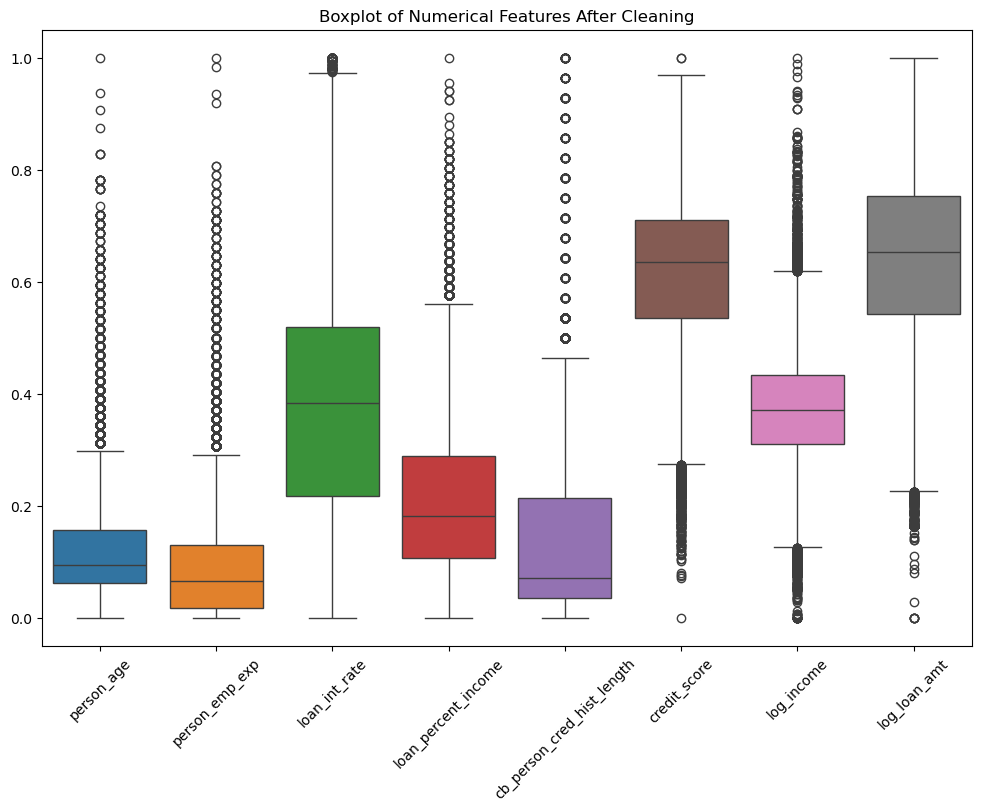

In [70]:
# Check cleaned data
df_cleaned.info()
df_cleaned.describe()

# Plot boxplot for cleaned data
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned[numerical_columns])
plt.title('Boxplot of Numerical Features After Cleaning')
plt.xticks(rotation=45)
plt.show()

<h4>Categorical Variables</h4>

<h5>  Regroup the Person Education </h5>

Since *Master* and *Doctorate* degrees are both Graduate degrees, we can combine those two categories into one and rename as *Graduate*.

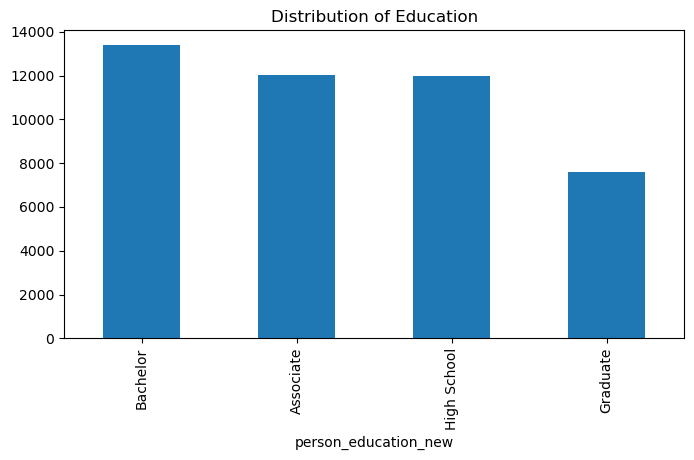

In [77]:
# Create the new mappings
grad_edu = {'Master': 'Graduate',
            'Doctorate': 'Graduate'
}

#Create new field with the updated values
df_cleaned['person_education_new'] = df['person_education'].replace(grad_edu)

#View the new distribution for education
fig = plt.figure(figsize=(8, 4))
df_cleaned['person_education_new'].value_counts().plot(kind='bar')
plt.title(f"Distribution of Education")
plt.show()

#Drop the original field
df_cleaned.drop('person_education', axis=1, inplace=True)

In [81]:
#Update the change log
changelog.append({
    'column': 'person_education',
    'change': 'Combined Master and Doctorate categories into one group -- Graduate',
    'rationale': 'Doctorate had the lowest frequency out of all the categories which could impact analysis',
})

<h5> Regroup the Home Ownership </h5>

In [72]:
#Create dataframe to hold the subset of data
other_home_ownership = df[df['person_home_ownership'] == 'OTHER']
#Find the number of records that fall into this subset
print("Number of records: ", len(other_home_ownership))

other_home_ownership.describe(include='all')


Number of records:  117


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,person_education_new
count,117.000000,117,117,117.000000,117.000000,117,117.000000,117,117.000000,117.000000,117.000000,117.000000,117,117.000000,117
unique,NaN,2,5,NaN,NaN,1,NaN,6,NaN,NaN,NaN,NaN,2,NaN,4
top,NaN,male,Bachelor,NaN,NaN,OTHER,NaN,VENTURE,NaN,NaN,NaN,NaN,No,NaN,Bachelor
freq,NaN,67,41,NaN,NaN,117,NaN,27,NaN,NaN,NaN,NaN,70,NaN,41
mean,26.897436,NaN,NaN,91480.068376,4.871795,NaN,11282.324786,NaN,12.032991,0.159402,5.358974,627.803419,NaN,0.333333,NaN
std,6.363127,NaN,NaN,94488.588654,6.311646,NaN,5963.710386,NaN,2.498724,0.090509,3.931442,51.840478,NaN,0.473432,NaN
min,21.000000,NaN,NaN,14988.000000,0.000000,NaN,1000.000000,NaN,7.400000,0.010000,2.000000,503.000000,NaN,0.000000,NaN
25%,23.000000,NaN,NaN,51596.000000,1.000000,NaN,7000.000000,NaN,10.770000,0.080000,3.000000,585.000000,NaN,0.000000,NaN
50%,24.000000,NaN,NaN,72093.000000,3.000000,NaN,10000.000000,NaN,11.830000,0.150000,4.000000,632.000000,NaN,0.000000,NaN
75%,28.000000,NaN,NaN,96409.000000,6.000000,NaN,15000.000000,NaN,14.110000,0.220000,8.000000,668.000000,NaN,1.000000,NaN


<Axes: xlabel='person_age', ylabel='Count'>

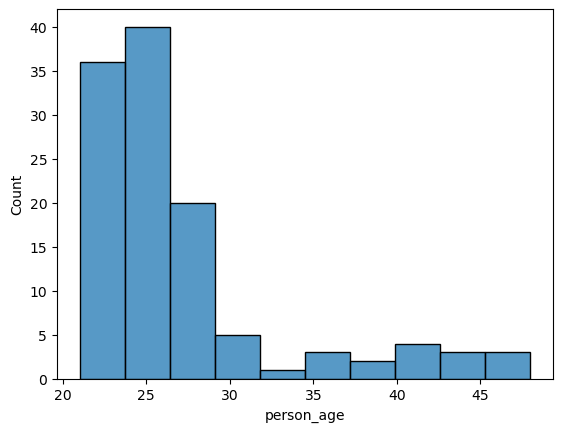

In [73]:
#Look at the distribution for age
sns.histplot(other_home_ownership['person_age'], bins=10)

Based on the output, it does look like majority of these people fall within their 20s, which suggests that "Other" could mean that they still live at home and someone else is the homeowner.

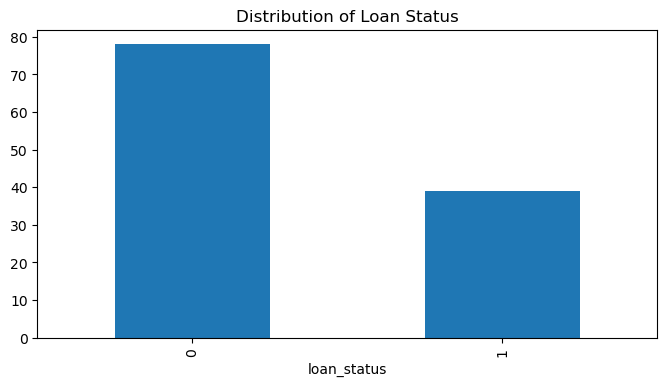

In [74]:
#Look at the distribution for loan amount
fig = plt.figure(figsize=(8, 4))
other_home_ownership['loan_status'].value_counts().plot(kind='bar')
plt.title(f"Distribution of Loan Status")
plt.show()

Within this subset of data, there is a difference in classes such that these records should remain in the dataset and the low frequency of the category should be handled so that it doesn't impact the analysis of the variable.

Since the *Rent* and *Mortgage* categories have high frequencies and *Own* and *Other* have lower frequencies, we can combine them into two groups *Homeowner* and *Non-Homeowner*. *Rent* and *Other* would fall under *Non-Homeowner** and *Mortgage* and *Own* would fall until *Homeowner*.

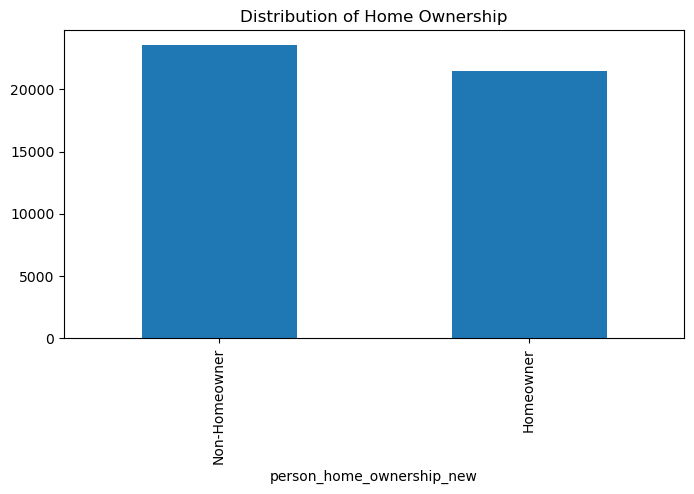

In [79]:
#Mapping for new categories
ownership = {'RENT': 'Non-Homeowner',
             'OTHER': 'Non-Homeowner',
             'MORTGAGE': 'Homeowner',
             'OWN': 'Homeowner'
}

#Create new field with the updated values
df_cleaned['person_home_ownership_new'] = df['person_home_ownership'].replace(ownership)

#View the new distribution
fig = plt.figure(figsize=(8, 4))
df_cleaned['person_home_ownership_new'].value_counts().plot(kind='bar')
plt.title(f"Distribution of Home Ownership")
plt.show()

#Drop the original field
df_cleaned.drop('person_home_ownership', axis=1, inplace=True)


In [ ]:
#Update the change log
changelog.append({
    'column': 'person_home_ownership',
    'change': 'Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category',
    'rationale': 'RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis',
})

In [85]:
# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,numerical_columns,Scaled numerical columns using MinMaxScaler,"Normalized numerical features to a range of [0, 1] for better model performance."
6,person_education,Combined Master and Doctorate categories into one group -- Graduate,Doctorate had the lowest frequency out of all the categories which could impact analysis
7,person_home_ownership,Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category,RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis
